In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 1
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory, get_gpu_device
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = False
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [9]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [10]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
0,0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976,False
1,1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393,False
2,2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691,False
3,3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181,False
4,4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246,False
5697958,5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382,False
5697959,5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200,False
5697960,5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274,False


In [11]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [12]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329
...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182


## Batches of ZTF Data Near Initial Candidate Elements

In [13]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [14]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [15]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,9472,0,b'ZTF18ablreca',582228440915015051,4429,58336.228449,275.623971,-19.732784,0.092245,-0.993751,...,0.063652,-0.994811,0.079366,1.669246,0.033041,6815.410019,0.999454,0.896032,False,False
1,9523,0,b'ZTF18ablrrmm',582228441515010169,4429,58336.228449,274.474165,-20.557661,0.073042,-0.996118,...,0.063652,-0.994811,0.079366,1.669246,0.031681,6534.850780,0.999498,0.823785,False,False
2,9524,0,b'ZTF18ablrrmm',583325941515010039,4533,58337.325949,274.474106,-20.557585,0.073041,-0.996118,...,0.061522,-0.994926,0.079609,1.676021,0.032596,6723.784176,0.999469,0.872104,False,False
3,83268,0,b'ZTF18abkiuvs',583325941515015015,4533,58337.325949,274.254244,-20.690837,0.069398,-0.996485,...,0.061522,-0.994926,0.079609,1.676021,0.033655,6942.119800,0.999434,0.929656,False,False
4,83271,0,b'ZTF18abkiuvs',582228441515015011,4429,58336.228449,274.254253,-20.690856,0.069398,-0.996485,...,0.063652,-0.994811,0.079366,1.669246,0.032988,6804.644809,0.999456,0.893204,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47351,5244546,63,b'ZTF20aanbicp',1139161934315015010,93033,58893.161933,37.471372,19.129852,0.749830,0.657697,...,0.748948,0.654175,0.105506,2.518142,0.033664,6944.105315,0.999433,0.930188,False,False
47352,5381276,63,b'ZTF18abomwia',1142181624015015000,94184,58896.181620,36.733350,20.616292,0.750104,0.653657,...,0.737167,0.667517,0.104914,2.561837,0.019494,4020.896645,0.999810,0.311897,False,False
47353,5381393,63,b'ZTF20aaogfkm',1142181623915015001,94184,58896.181620,39.193902,19.790850,0.729236,0.680236,...,0.737167,0.667517,0.104914,2.561837,0.034247,7064.277329,0.999414,0.962658,False,False
47354,5445787,63,b'ZTF20aapczfl',1145109243715015002,94770,58899.109248,38.029908,20.665282,0.737008,0.669246,...,0.725274,0.680505,0.104353,2.603903,0.019017,3922.518773,0.999819,0.296822,False,False


In [16]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [17]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [18]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [19]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :    47356   (      740)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     105.28
Sqrt(batch_obs):      27.20
Mean t_score   :       4.36


In [21]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,2.544333,0.209350,-0.341241,0.106091,4.521271,2.275609,58600.0,1611,405.620375,10.105830,10,0.008727,0.034905,16.5,4.0
1,1,3.022120,0.388701,2.045759,0.091330,4.833602,0.818635,58600.0,1210,331.403807,9.527190,10,0.008727,0.034905,16.5,4.0
2,2,2.658252,0.084018,-0.200892,0.054430,3.919254,3.036481,58600.0,1482,296.036045,7.689896,10,0.008727,0.034905,16.5,4.0
3,3,3.173817,0.119381,0.065729,0.101663,3.854650,3.433540,58600.0,878,248.403326,8.383206,10,0.008727,0.034905,16.5,4.0
4,4,2.558488,0.247786,-0.754779,0.065962,3.944458,3.127290,58600.0,1550,202.217491,5.136329,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,3.180329,0.144169,-0.069335,0.095246,0.084546,0.175799,58600.0,881,54.676130,1.842086,10,0.008727,0.034905,16.5,4.0
60,60,3.191399,0.080179,1.912886,0.080646,2.185491,3.813534,58600.0,478,54.236576,2.480723,10,0.008727,0.034905,16.5,4.0
61,61,2.349225,0.200286,2.068264,0.096268,1.322709,5.337065,58600.0,122,53.581222,4.851016,10,0.008727,0.034905,16.5,4.0
62,62,3.154451,0.081705,-4.248868,0.304007,2.652238,2.144825,58600.0,434,53.002095,2.544182,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [22]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [23]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [24]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_rand_unknown_{random_seed:04d}.h5',
                name='model')

In [25]:
# model.load()

In [26]:
# raise ValueError

In [27]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     3.36  :   0.00 :  1794.61 :  7200.00
Mean     :     3.36  :   0.00 :  1794.61 :  7200.00
Median   :     2.02  :   0.00 :  1792.82 :  7200.00
GeoMean  :     2.38  :   0.00 :  1794.61 :  7200.99
Min      :     0.69  :   0.00 :  1792.82 :  7200.00
Max      :    25.43  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


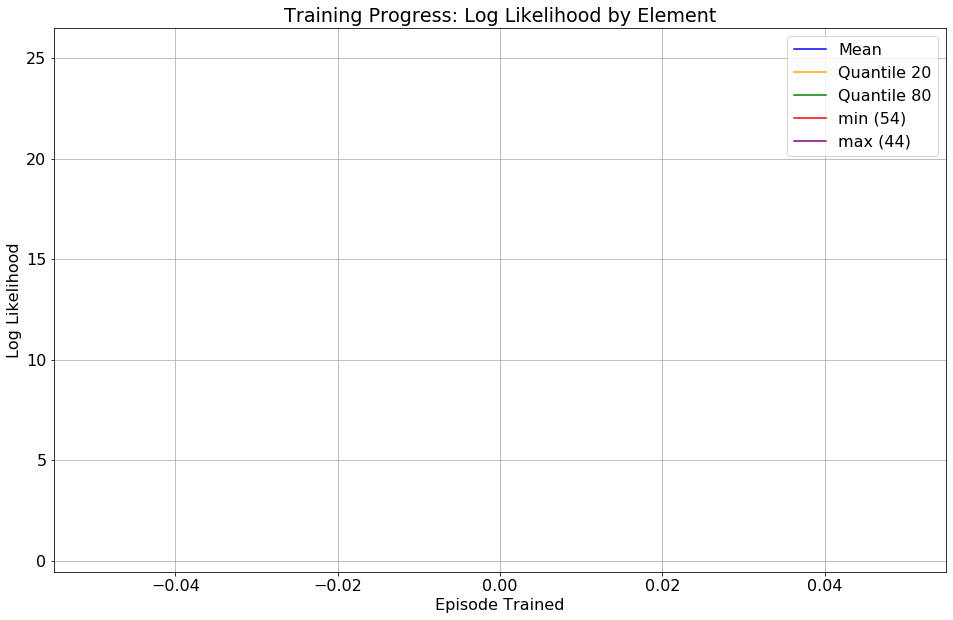

In [28]:
fig, ax = model.plot_hist(att_name='log_like', x_axis='episode')

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 932us/sample - loss: -321753.3667
Epoch 2/4
4096/4096 [==============================] - 1s 282us/sample - loss: -417377.4873
Epoch 3/4
4096/4096 [==============================] - 1s 286us/sample - loss: -528200.7642
Epoch 4/4
4096/4096 [==============================] - 1s 283us/sample - loss: -649698.0898
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1170.41 :  1170.41 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      6.18 :     6.18 :      nan
Mean Hits           :      

/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


4096/4096 [==============================] - 1s 294us/sample - loss: -773978.5752
Epoch 6/8
4096/4096 [==============================] - 1s 292us/sample - loss: -890833.2178
Epoch 7/8
4096/4096 [==============================] - 1s 281us/sample - loss: -990137.8701
Epoch 8/8
4096/4096 [==============================] - 1s 301us/sample - loss: -1068799.7852
Adjusted element weight down on 3 candidate elements. Mean weight = 9.77e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    987.08 :   987.08 :      nan arc seconds
Geom Mean Threshold :   7193.55 :  7193.55 :      nan arc seconds
Mean Log Likelihood :      7.96 :     7.96 :      nan
Mean Hits           :      0.00 :     0.00 :      nan
Good Elements       :      0.00

********************************************************************************
Terminating: Completed 512 batches.
********************************************************************************

Good elements (hits >= 10):   0.0

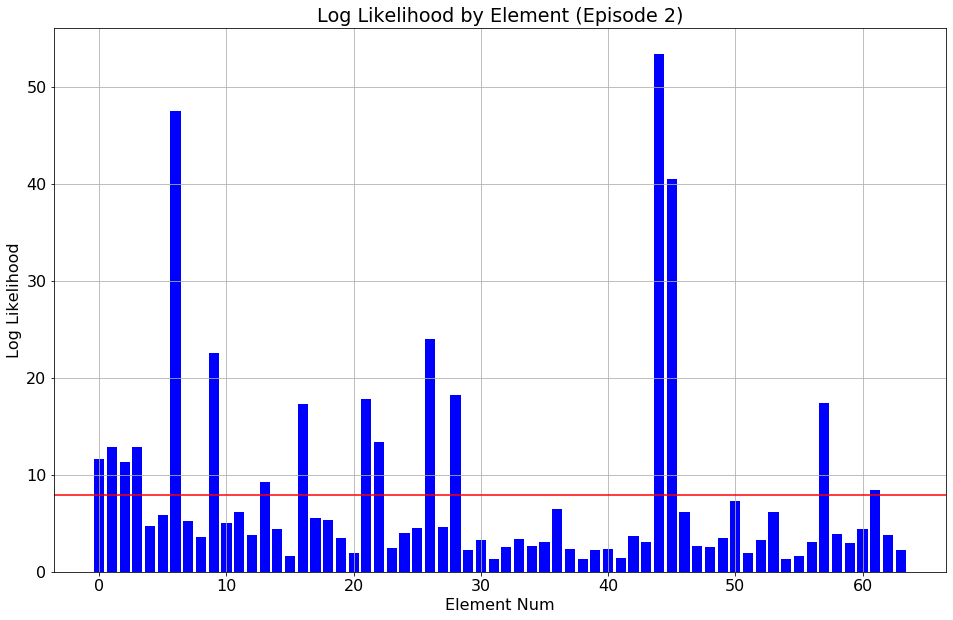

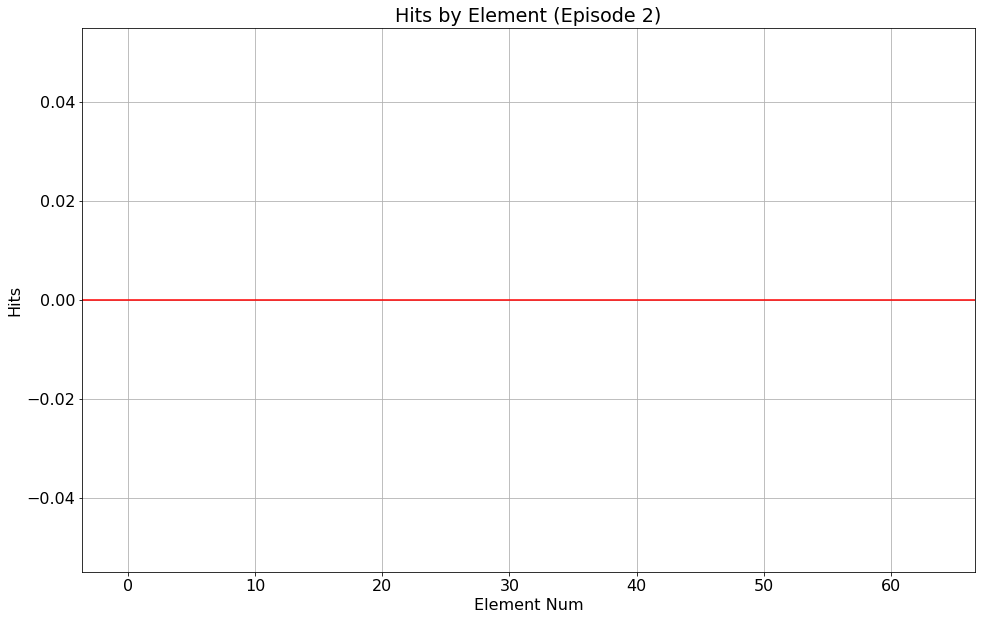


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.384e-04, training_time 22 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -537.9897
Epoch 10/12
4096/4096 [==============================] - 2s 409us/sample - loss: -668.3487
Epoch 11/12
4096/4096 [==============================] - 2s 404us/sample - loss: -731.8870
Epoch 12/12
4096/4096 [==============================] - 2s 410us/sample - loss: -776.4872
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    961.38 :   961.38 :      nan arc seconds
Geom Mean Threshold :   7196.43 :  7196.43 :      nan arc seconds
Mean Log Likelihood :     19.86 :    19.86 : 

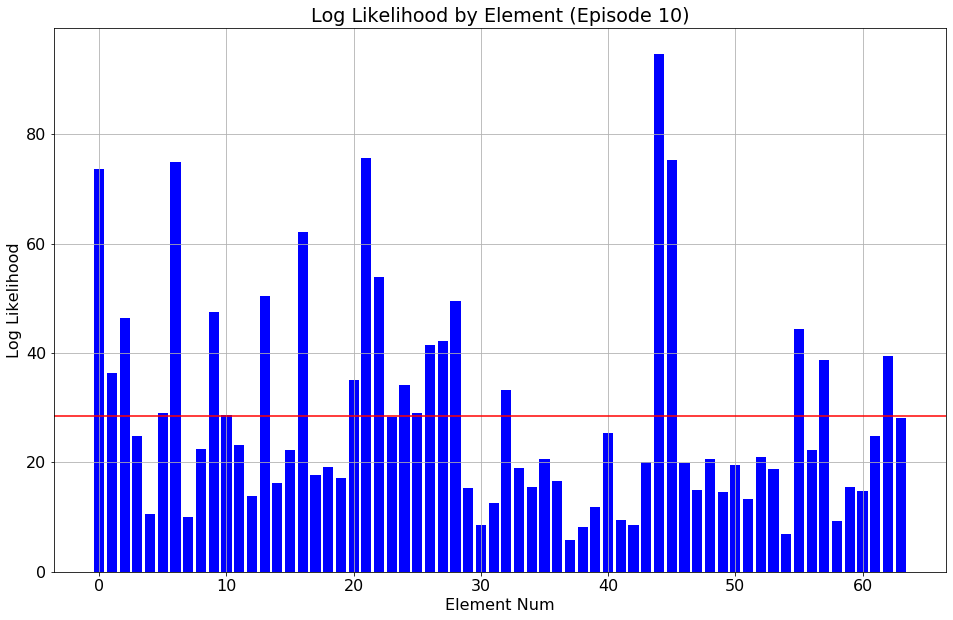

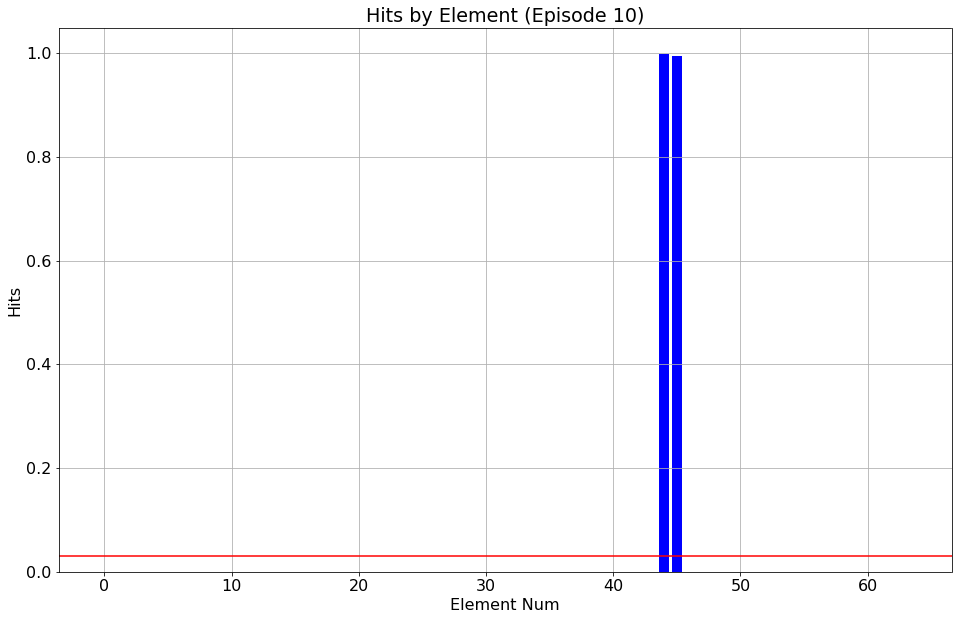


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 94 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 4s 860us/sample - loss: -4396685.0703
Epoch 42/44
4096/4096 [==============================] - 1s 333us/sample - loss: -5104270.8359
Epoch 43/44
4096/4096 [==============================] - 1s 338us/sample - loss: -5778177.3516
Epoch 44/44
4096/4096 [==============================] - 1s 346us/sample - loss: -6420841.2266
Adjusted element weight down on 4 candidate elements. Mean weight = 9.69e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    551.47 :   551.47 :      nan arc seconds
Geom Mean Threshold :   5322.79 :  5322.79 :      nan ar

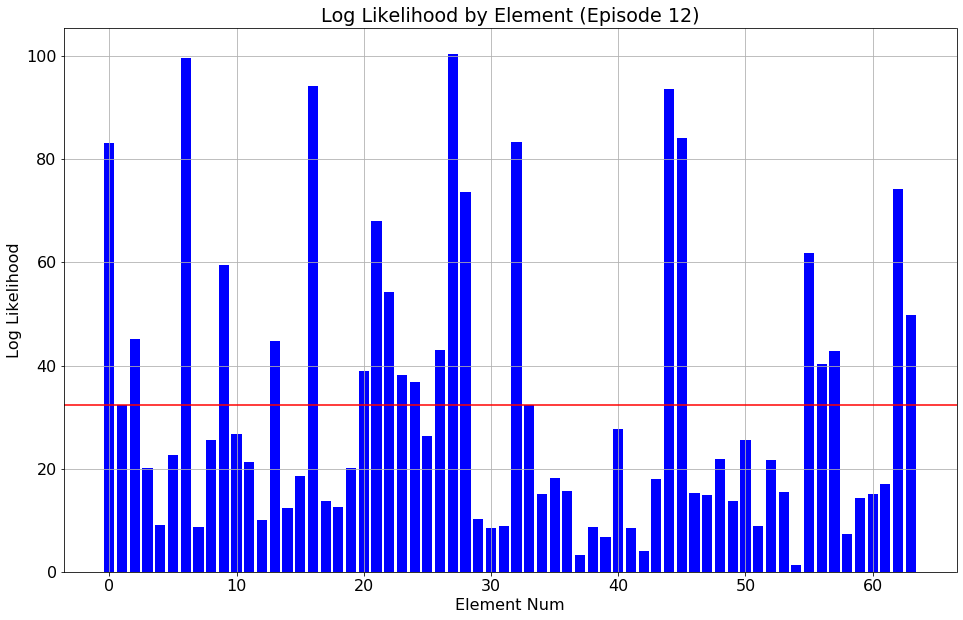

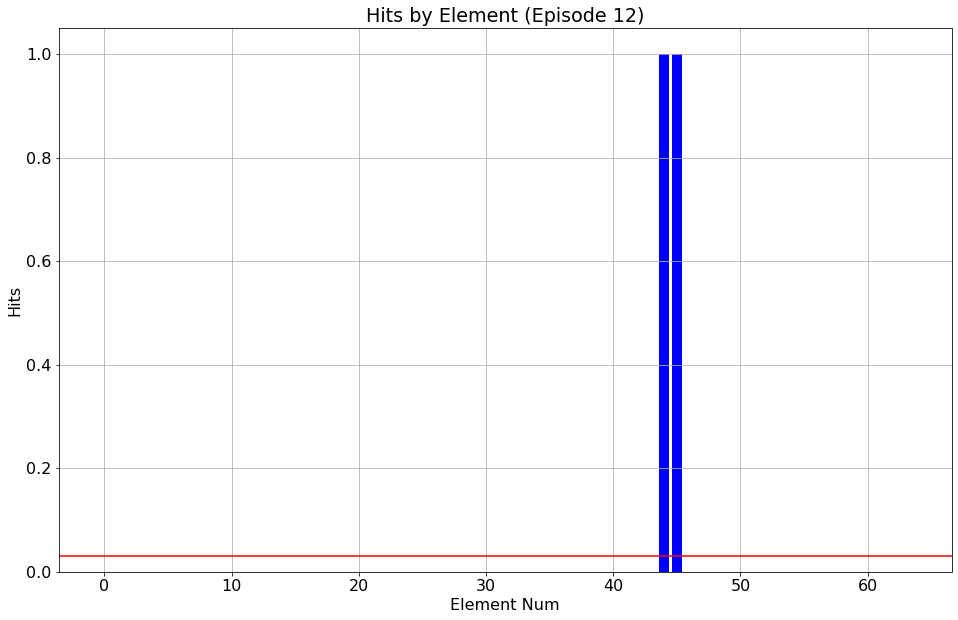


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.031e-04, training_time 111 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -1294.2118
Epoch 50/52
4096/4096 [==============================] - 2s 464us/sample - loss: -1323.8372
Epoch 51/52
4096/4096 [==============================] - 2s 461us/sample - loss: -1339.2320
Epoch 52/52
4096/4096 [==============================] - 2s 462us/sample - loss: -1350.9999
Adjusted element weight down on 4 candidate elements. Mean weight = 4.52e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    472.75 :   472.75 :      nan arc seconds
Geom Mean Threshold :   514

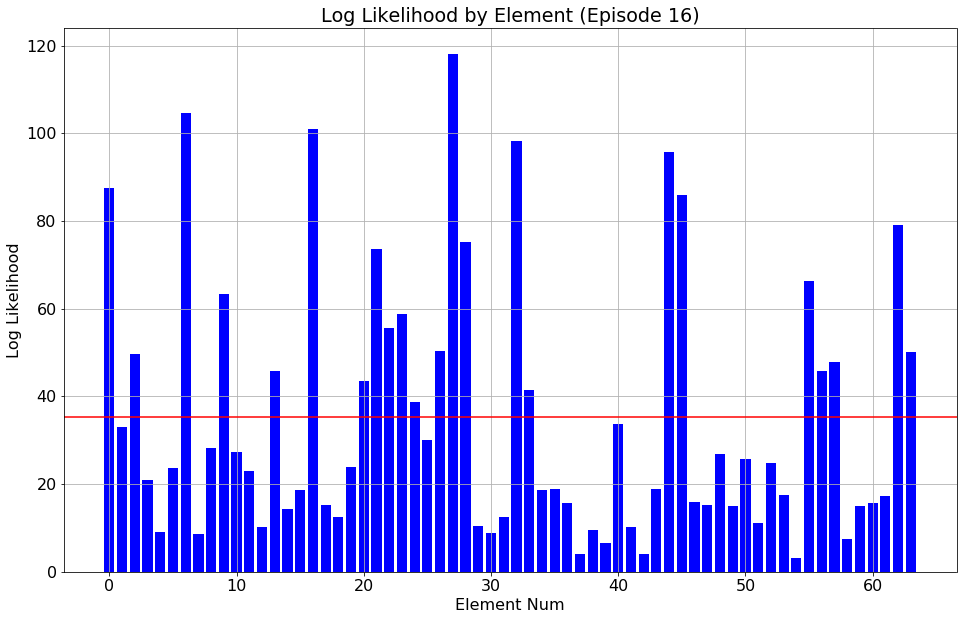

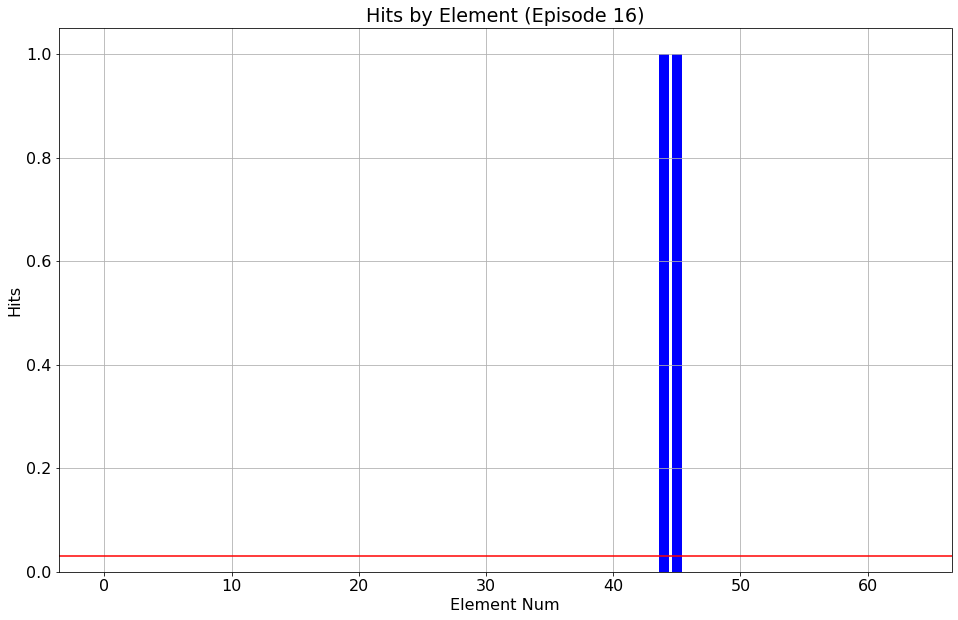


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 16: Epoch   64, Batch   4096
effective_learning_rate=2.441e-04, training_time 151 sec.
Train on 4096 samples
Epoch 65/68
4096/4096 [==============================] - 4s 856us/sample - loss: -11195679.3750
Epoch 66/68
4096/4096 [==============================] - 2s 370us/sample - loss: -11917397.5000
Epoch 67/68
4096/4096 [==============================] - 2s 371us/sample - loss: -12546781.5000
Epoch 68/68
4096/4096 [==============================] - 2s 371us/sample - loss: -13073246.1406
Adjusted element weight down on 27 candidate elements. Mean weight = 7.89e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    413.65 :   413.65 :      nan arc seconds
Geom Mean Threshold :   3491.47 :  3491.47 :      

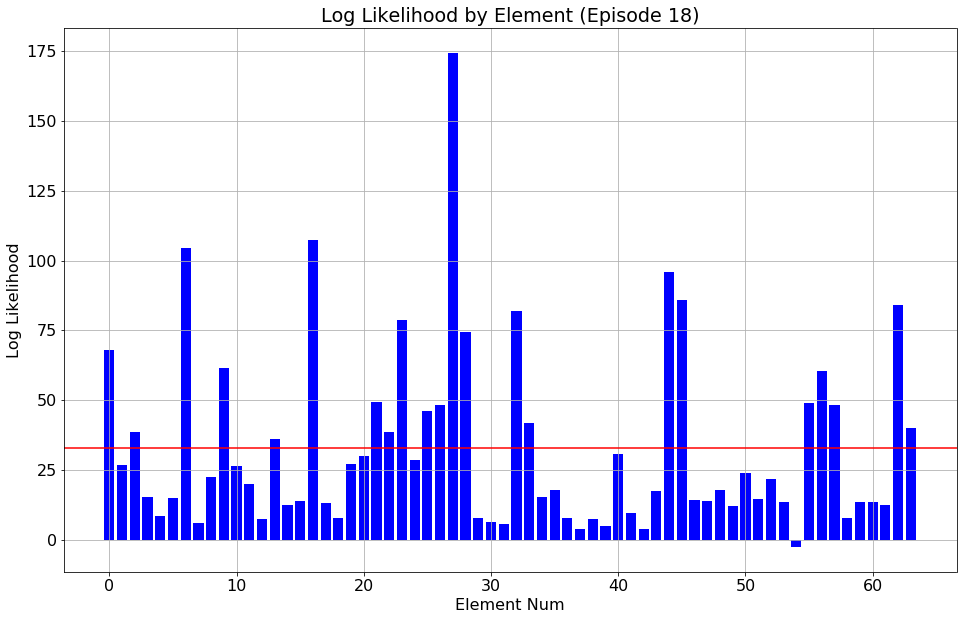

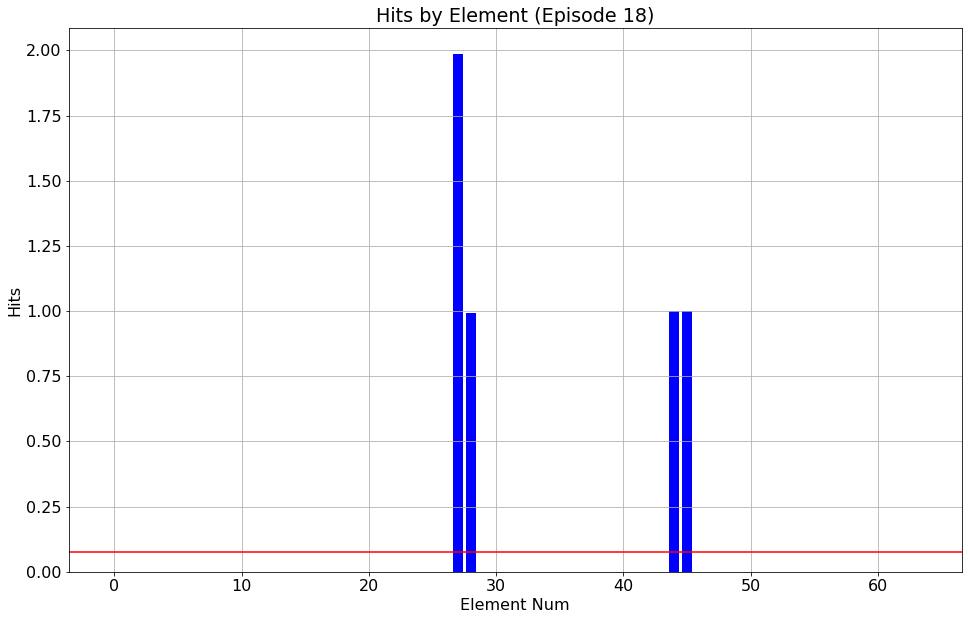


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 18: Epoch   72, Batch   4608
effective_learning_rate=1.354e-04, training_time 168 sec.
Train on 4096 samples
Epoch 73/76
4096/4096 [==============================] - 5s 1ms/sample - loss: -883.7020
Epoch 74/76
4096/4096 [==============================] - 2s 494us/sample - loss: -897.3442
Epoch 75/76
4096/4096 [==============================] - 2s 483us/sample - loss: -907.2850
Epoch 76/76
4096/4096 [==============================] - 2s 477us/sample - loss: -914.1658
Adjusted element weight down on 7 candidate elements. Mean weight = 5.36e-02
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    394.72 :   394.72 :      nan arc seconds
Geom Mean Threshold :   3446.30

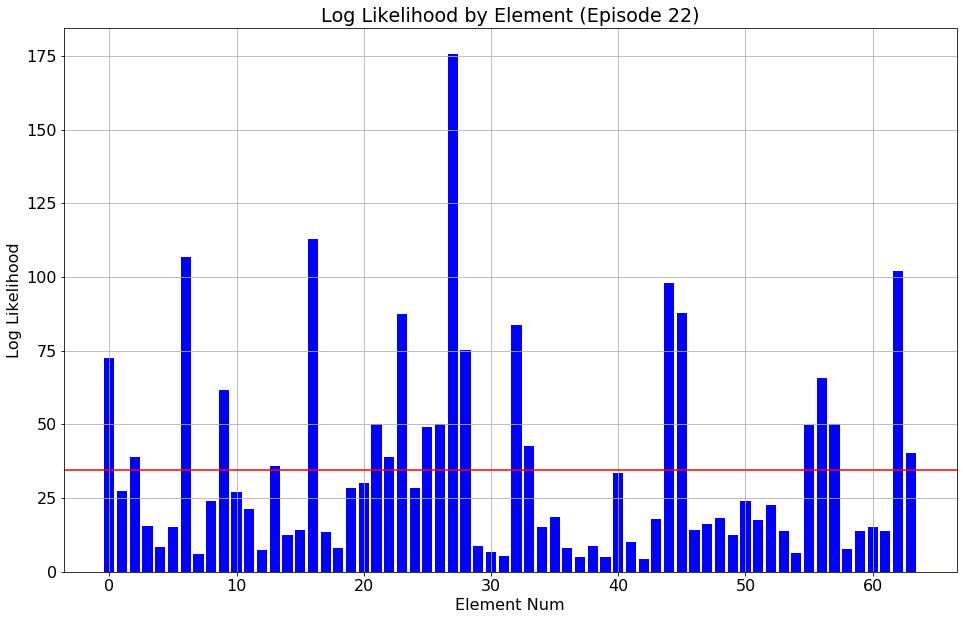

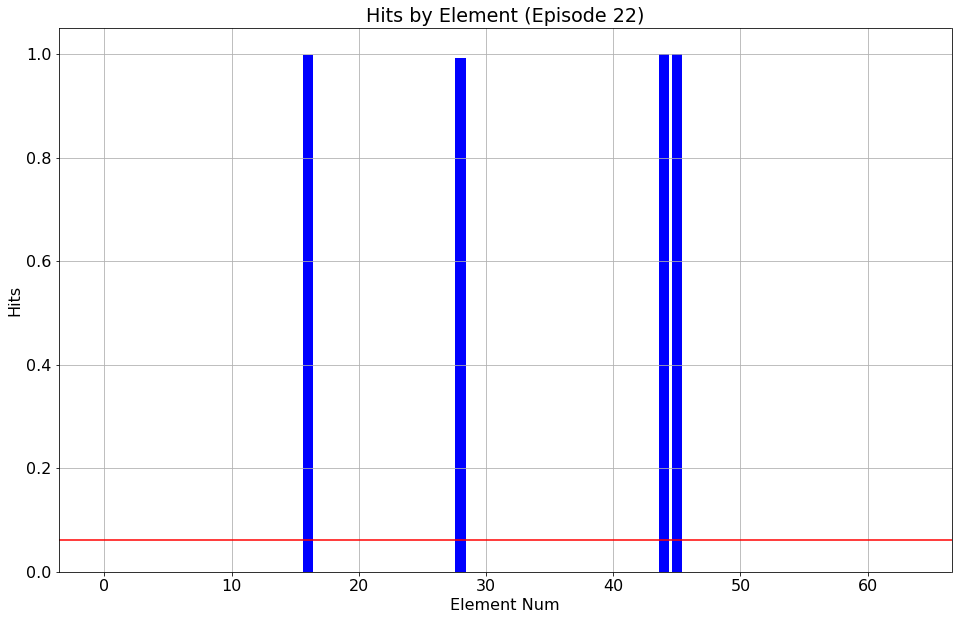


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 22: Epoch   88, Batch   5632
effective_learning_rate=2.441e-04, training_time 210 sec.
Train on 4096 samples
Epoch 89/92
4096/4096 [==============================] - 4s 915us/sample - loss: -16435395.6406
Epoch 90/92
4096/4096 [==============================] - 2s 380us/sample - loss: -17197826.5000
Epoch 91/92
4096/4096 [==============================] - 2s 395us/sample - loss: -17762957.3438
Epoch 92/92
4096/4096 [==============================] - 2s 387us/sample - loss: -18195581.9375
Adjusted element weight down on 33 candidate elements. Mean weight = 7.42e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    356.39 :   356.39 :      nan arc seconds
Geom Mean Threshold :   2355.07 :  2355.07 :      

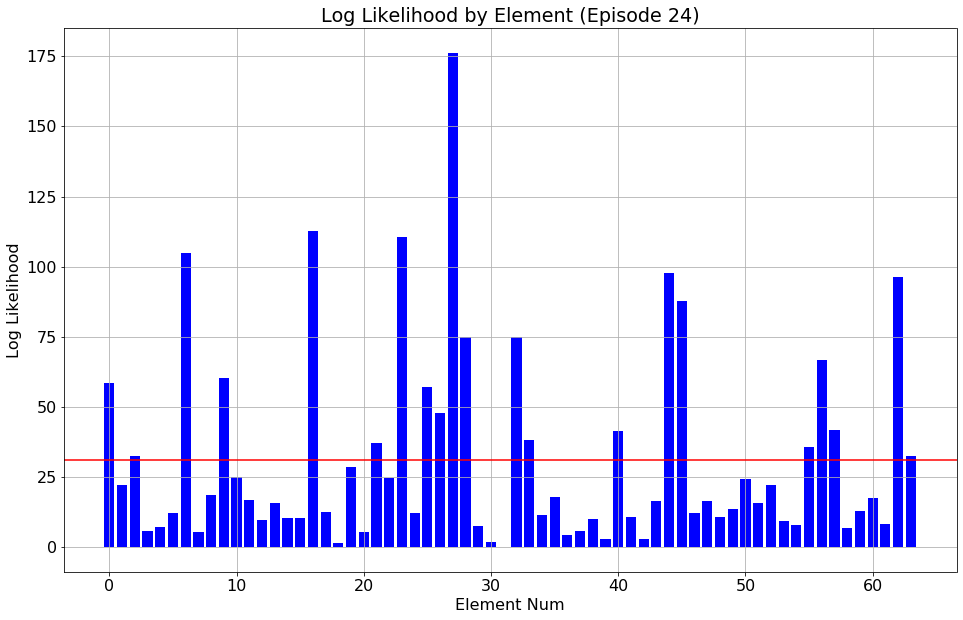

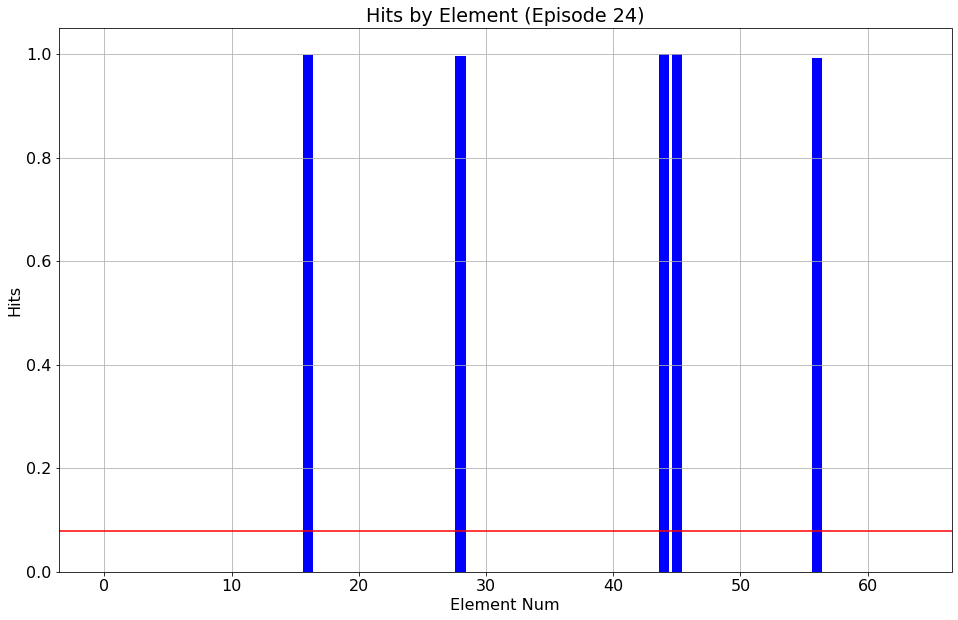


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 24: Epoch   96, Batch   6144
effective_learning_rate=1.183e-04, training_time 228 sec.
Train on 4096 samples
Epoch 97/100
4096/4096 [==============================] - 5s 1ms/sample - loss: -568.7627
Epoch 98/100
4096/4096 [==============================] - 2s 530us/sample - loss: -575.3510
Epoch 99/100
4096/4096 [==============================] - 2s 518us/sample - loss: -580.3544
Epoch 100/100
4096/4096 [==============================] - 2s 535us/sample - loss: -584.8070
Adjusted element weight down on 64 candidate elements. Mean weight = 3.35e-03
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    342.42 :   342.42 :      nan ar

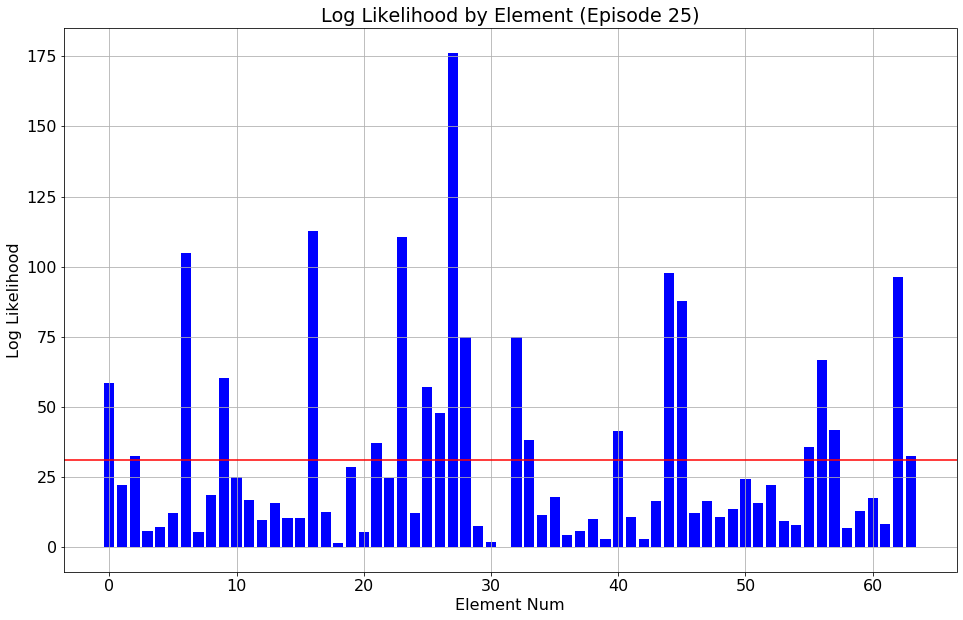

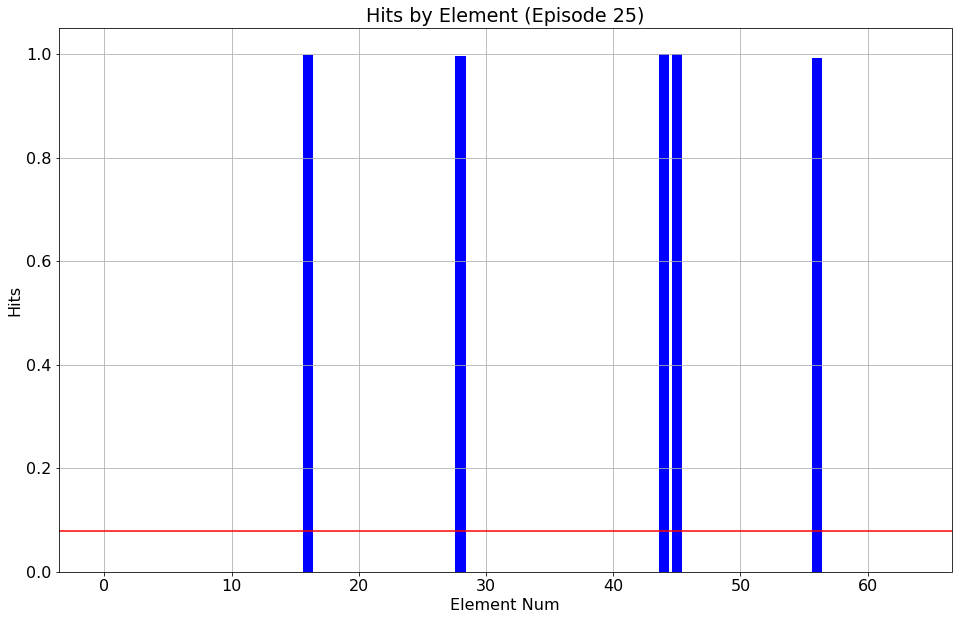


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 25: Epoch  100, Batch   6400
effective_learning_rate=1.221e-04, training_time 241 sec.
Train on 4096 samples
Epoch 101/104
4096/4096 [==============================] - 4s 950us/sample - loss: -254904879616.0000
Epoch 102/104
4096/4096 [==============================] - 2s 401us/sample - loss: -269393981184.0000
Epoch 103/104
4096/4096 [==============================] - 2s 408us/sample - loss: -283572467712.0000
Epoch 104/104
4096/4096 [==============================] - 2s 404us/sample - loss: -296997580800.0000
Adjusted element weight down on 61 candidate elements. Mean weight = 5.23e-01
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    340.76 :   340.76 :    

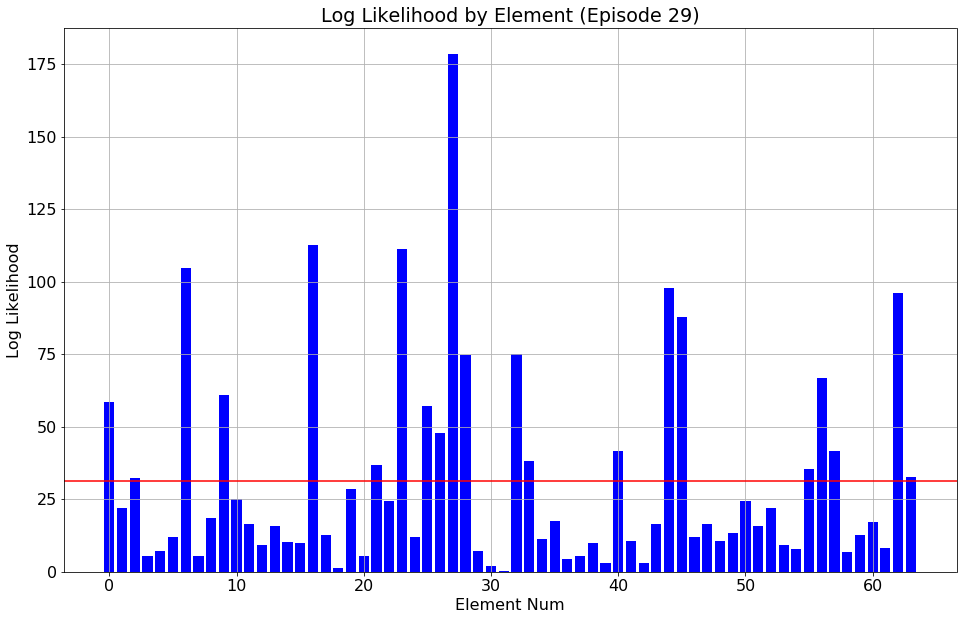

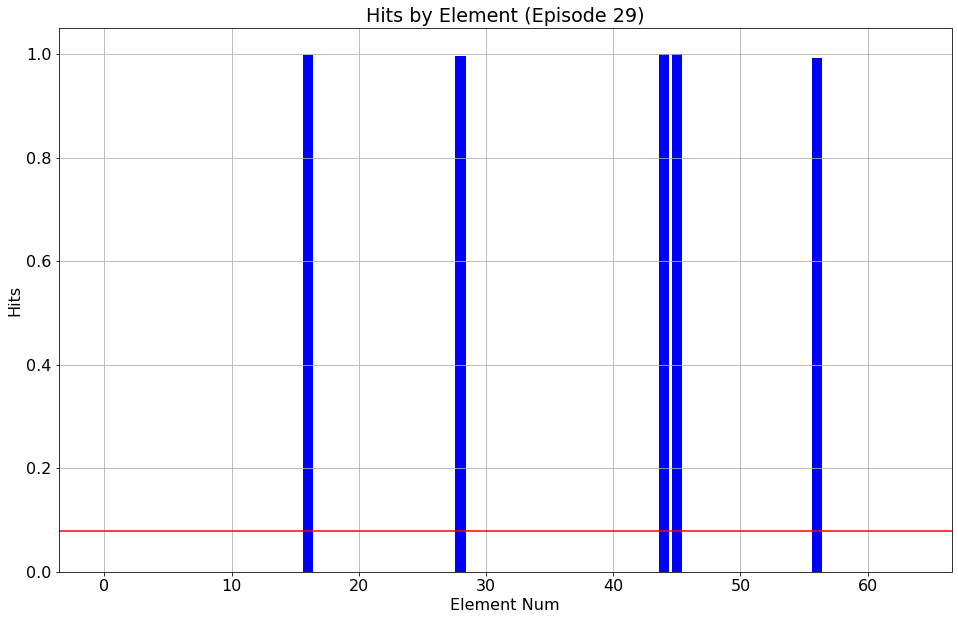


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 29: Epoch  116, Batch   7424
effective_learning_rate=3.815e-06, training_time 274 sec.
Train on 4096 samples
Epoch 117/120
4096/4096 [==============================] - 5s 1ms/sample - loss: -1416847.2715
Epoch 118/120
4096/4096 [==============================] - 2s 549us/sample - loss: -1424621.1855
Epoch 119/120
4096/4096 [==============================] - 2s 544us/sample - loss: -1429932.1152
Epoch 120/120
4096/4096 [==============================] - 2s 535us/sample - loss: -1435652.8164
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    334.86 :   3

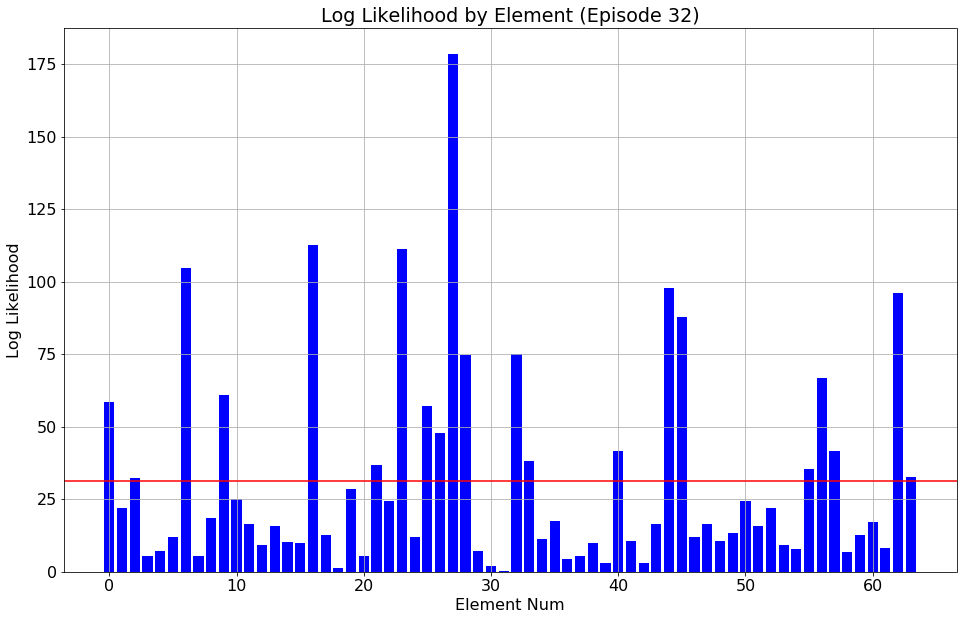

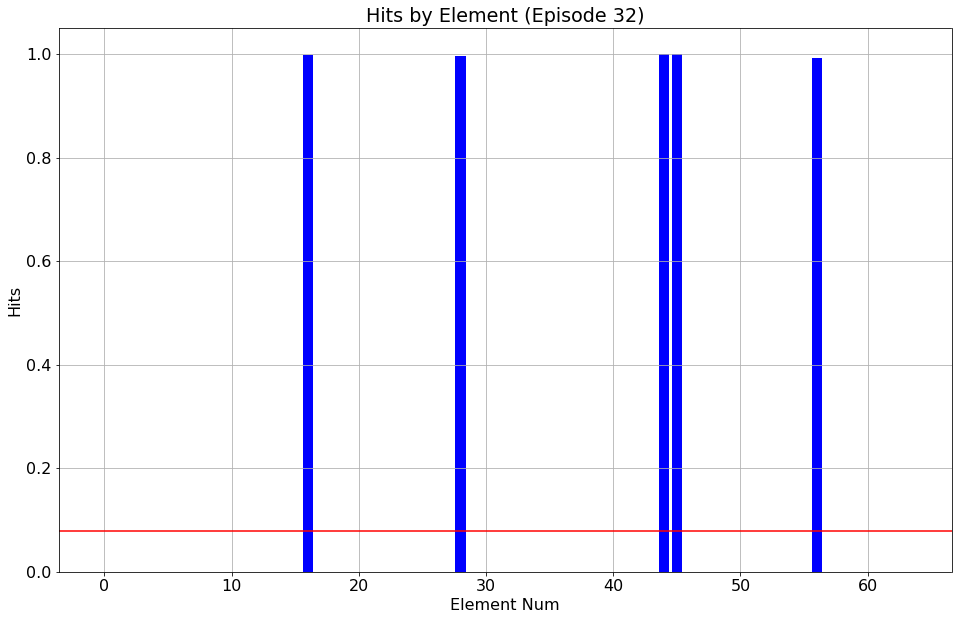


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 32: Epoch  128, Batch   8192
effective_learning_rate=3.815e-06, training_time 308 sec.
Train on 4096 samples
Epoch 129/132
4096/4096 [==============================] - 5s 1ms/sample - loss: -20544760864.0000
Epoch 130/132
4096/4096 [==============================] - 2s 577us/sample - loss: -20665546848.0000
Epoch 131/132
4096/4096 [==============================] - 2s 576us/sample - loss: -20764293376.0000
Epoch 132/132
4096/4096 [==============================] - 2s 569us/sample - loss: -20865475616.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution: 

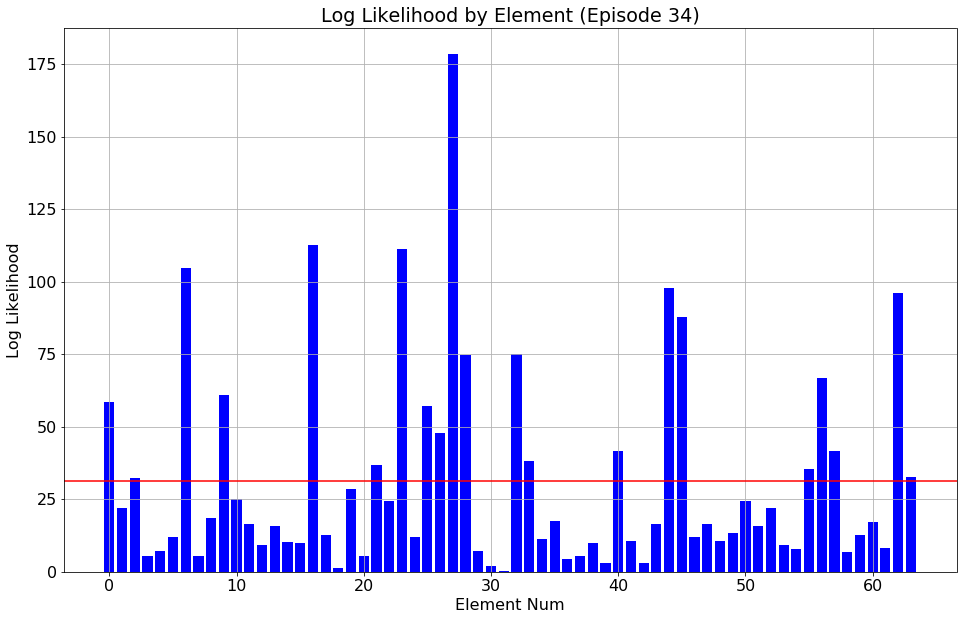

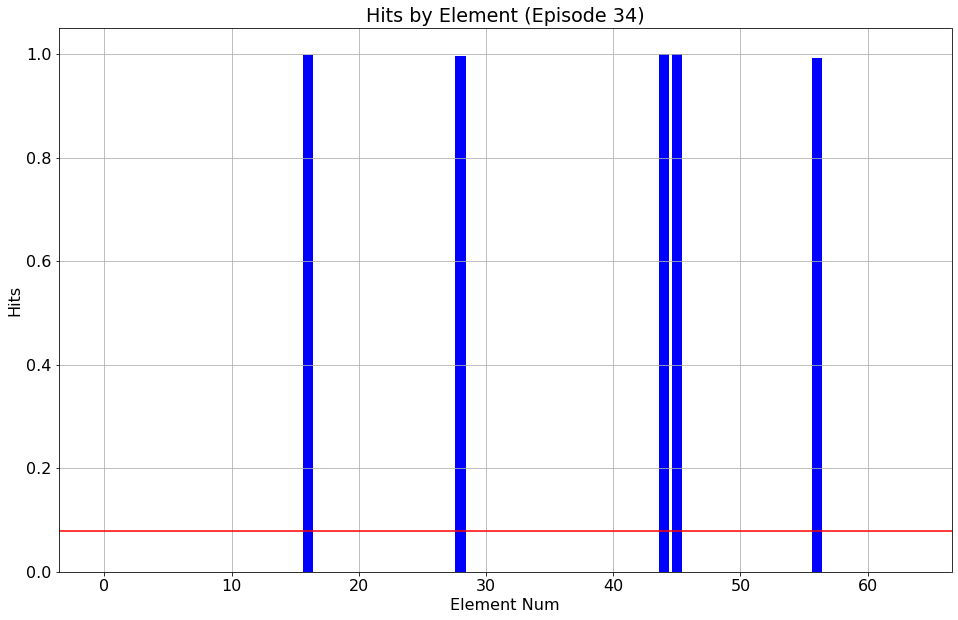

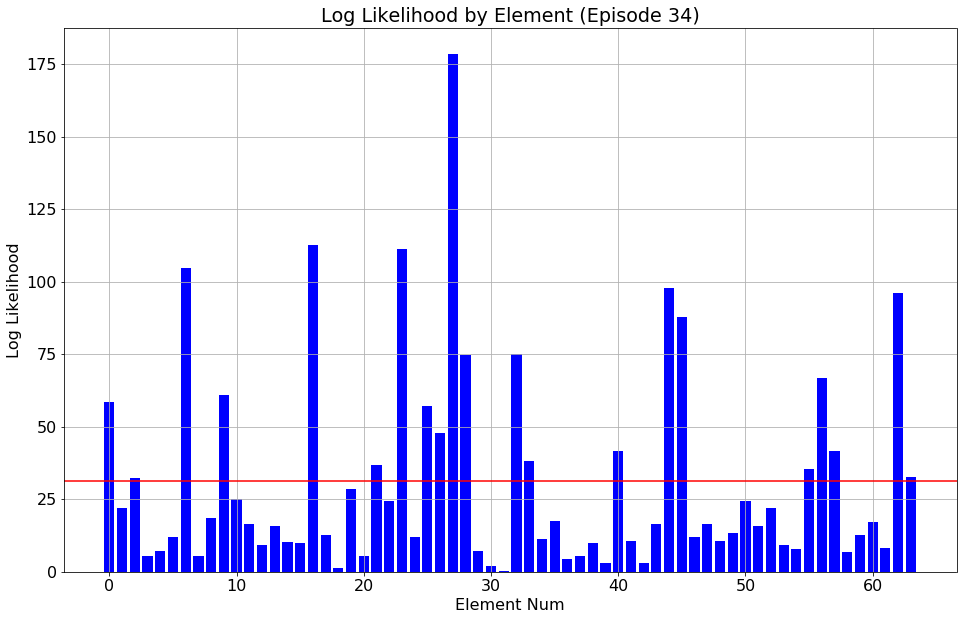

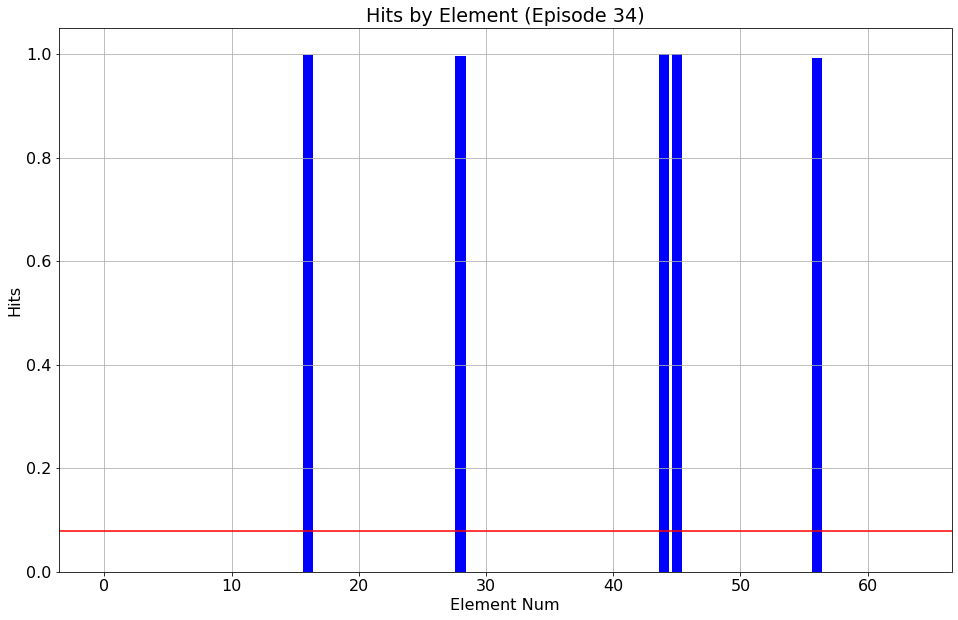

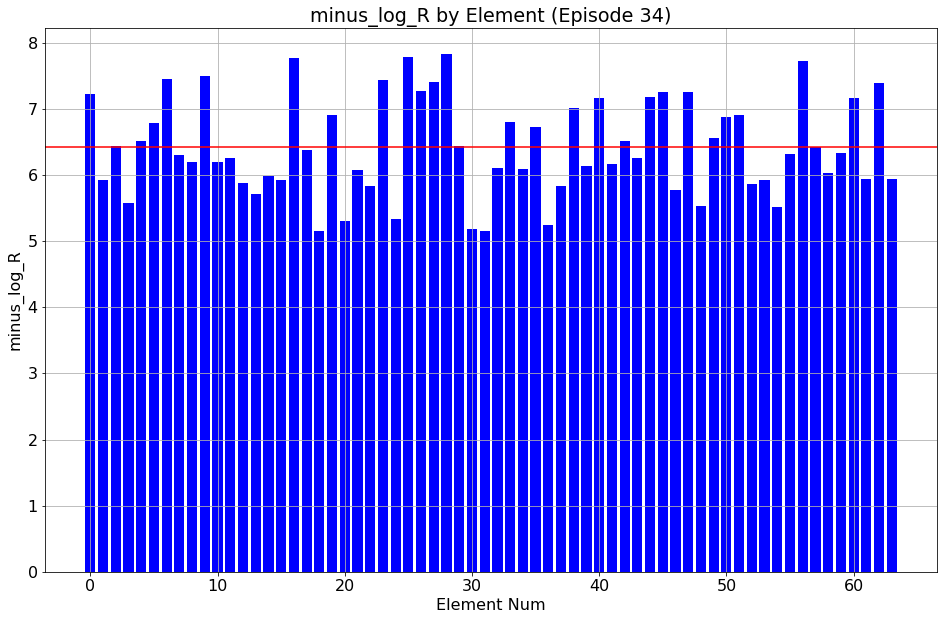

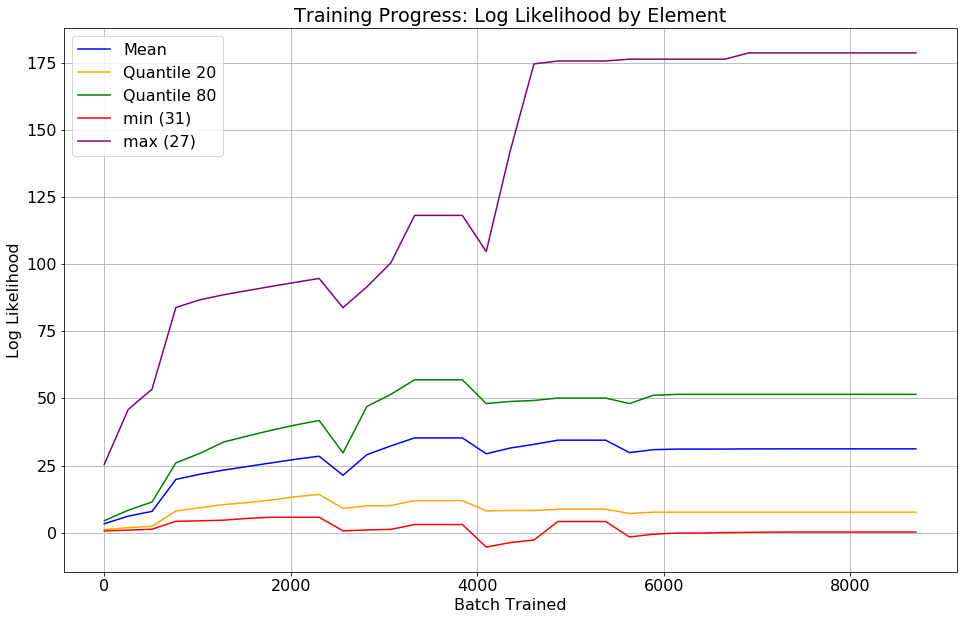

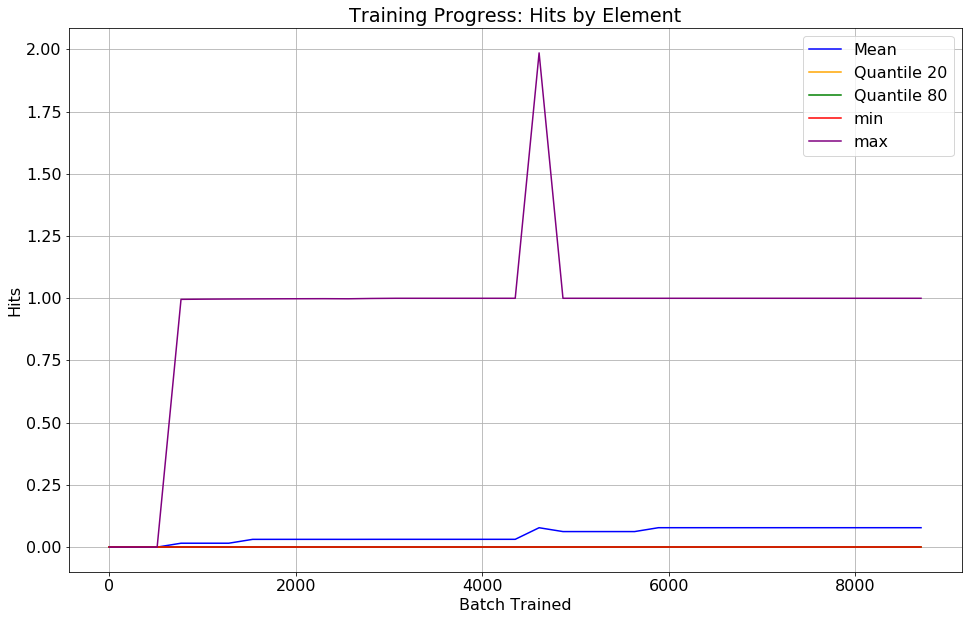

In [29]:
model.sieve(nearest_ast=False)

## Review Results Graphically

In [30]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [31]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [32]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [33]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [34]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

In [35]:
self = model

In [36]:
hist = self.train_hist_elt

In [37]:
hist

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,hits,num_rows_close,...,e_,inc_,Omega_,omega_,f_,num_hits_,R_,weight_joint,weight_element,weight_mixture
0,0,0,0,0,0,0,0.000000,4.589518,0.0,1611.0,...,0.209350,0.535784,0.719583,0.362174,-0.054310,0.099876,0.914866,1.00,1.0,1.0000
1,1,1,1,0,0,0,0.000000,5.025594,0.0,1210.0,...,0.388701,0.530805,0.769292,0.130290,0.325593,0.099876,0.914866,1.00,1.0,1.0000
2,2,2,2,0,0,0,0.000000,3.692850,0.0,1481.0,...,0.084018,0.518359,0.623769,0.483271,-0.031973,0.099876,0.914866,1.00,1.0,1.0000
3,3,3,3,0,0,0,0.000000,4.909733,0.0,878.0,...,0.119381,0.534290,0.613487,0.546465,0.010461,0.099876,0.914866,1.00,1.0,1.0000
4,4,4,4,0,0,0,0.000000,1.776806,0.0,1550.0,...,0.247786,0.522249,0.627780,0.497724,-0.120127,0.099876,0.914866,1.00,1.0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2235,59,59,34,136,8704,335.053257,12.748080,0.0,119.0,...,0.127656,0.531760,0.020122,0.022188,-0.013139,0.250385,0.831893,0.25,1.0,0.0625
2236,2236,60,60,34,136,8704,335.053257,17.297783,0.0,66.0,...,0.069335,0.525677,0.343682,0.607405,0.306471,0.131311,0.716212,0.25,1.0,0.0625
2237,2237,61,61,34,136,8704,335.053257,8.179095,0.0,33.0,...,0.210606,0.531151,0.209053,0.852308,0.330837,0.179155,0.888043,0.25,1.0,0.0625
2238,2238,62,62,34,136,8704,335.053257,96.244499,0.0,111.0,...,0.059985,0.604958,0.423600,0.339888,-0.679314,0.353556,0.683837,0.25,1.0,0.0625


In [38]:
episode = 4
mask = (hist.episode == episode)
elts = hist[mask]
elts

,key,element_num,element_id,episode,epoch,batch,training_time,log_like,hits,num_rows_close,...,e_,inc_,Omega_,omega_,f_,num_hits_,R_,weight_joint,weight_element,weight_mixture
256,256,0,0,4,16,1024,41.986722,54.921604,0.0,1461.0,...,0.208236,0.532961,0.724272,0.357110,-0.051643,0.266502,0.804757,1.0,1.0,1.0
257,257,1,1,4,16,1024,41.986722,30.183178,0.0,1066.0,...,0.388169,0.530787,0.768465,0.131184,0.325793,0.263778,0.821351,1.0,1.0,1.0
258,258,2,2,4,16,1024,41.986722,39.466106,0.0,1223.0,...,0.084064,0.519977,0.624499,0.483730,-0.031589,0.269366,0.802094,1.0,1.0,1.0
259,259,3,3,4,16,1024,41.986722,18.400137,0.0,841.0,...,0.122227,0.534790,0.610193,0.548549,0.010453,0.261716,0.826012,1.0,1.0,1.0
260,260,4,4,4,16,1024,41.986722,8.901864,0.0,1489.0,...,0.245579,0.522617,0.626506,0.497553,-0.117053,0.225081,0.752558,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,315,59,59,4,16,1024,41.986722,9.655411,0.0,830.0,...,0.143672,0.531361,0.013978,0.026930,-0.011988,0.173160,0.767066,1.0,1.0,1.0
316,316,60,60,4,16,1024,41.986722,11.106360,0.0,438.0,...,0.078444,0.526196,0.346831,0.606865,0.304252,0.215954,0.814109,1.0,1.0,1.0
317,317,61,61,4,16,1024,41.986722,23.873581,0.0,98.0,...,0.205906,0.531993,0.212453,0.850516,0.329002,0.208368,0.850786,1.0,1.0,1.0
318,318,62,62,4,16,1024,41.986722,26.483131,0.0,350.0,...,0.076093,0.605510,0.422383,0.341156,-0.676714,0.241049,0.896035,1.0,1.0,1.0


In [39]:
summary = self.train_hist_summary

In [40]:
summary

,key,episode,epoch,batch,training_time,loss,learning_rate,log_like_mean,log_like_med,log_like_std,...,thresh_sec_q20,thresh_sec_q80,log_thresh_mean,log_thresh_std,log_thresh_min,log_thresh_max,log_thresh_q20,log_thresh_q80,candidate_elements_trainable,mixture_parameters_trainable
0,0,0,0,0,0.000000,47352.0,0.000244,3.360853,2.021412,4.009971,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,False,True
1,1,1,4,256,17.553350,47352.0,0.000244,6.184319,3.221191,7.541106,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,False,True
2,2,2,8,512,22.474634,47351.0,0.000015,7.959668,3.921274,10.228704,...,7199.998535,7199.998535,-3.356028,7.119521e-03,-3.412537,-3.355131,-3.355131,-3.355131,True,True
3,3,3,12,768,33.809878,41923.0,0.000015,19.858173,14.776928,16.363235,...,7199.998535,7199.998535,-3.355626,3.932236e-03,-3.386837,-3.355131,-3.355131,-3.355131,True,True
4,4,4,16,1024,41.986722,41304.0,0.000015,21.782974,16.141605,17.065516,...,7199.998535,7199.998535,-3.355223,7.335963e-04,-3.361046,-3.355131,-3.355131,-3.355131,True,True
5,5,5,20,1280,50.391133,40917.0,0.000015,23.315456,16.938229,17.619833,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
6,6,6,24,1536,58.840956,40736.0,0.000015,24.665722,18.110912,18.221949,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
7,7,7,28,1792,67.425000,40546.0,0.000015,26.010521,18.968954,18.749706,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
8,8,8,32,2048,76.121003,40361.0,0.000015,27.327000,20.342276,19.143927,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True
9,9,9,36,2304,84.993241,40241.0,0.000015,28.491747,21.654385,19.526009,...,7199.998535,7199.998535,-3.355131,0.000000e+00,-3.355131,-3.355131,-3.355131,-3.355131,True,True


In [41]:
episode = 4
mask = (summary.episode <= episode)

In [42]:
summary[mask]

,key,episode,epoch,batch,training_time,loss,learning_rate,log_like_mean,log_like_med,log_like_std,...,thresh_sec_q20,thresh_sec_q80,log_thresh_mean,log_thresh_std,log_thresh_min,log_thresh_max,log_thresh_q20,log_thresh_q80,candidate_elements_trainable,mixture_parameters_trainable
0,0,0,0,0,0.000000,47352.0,0.000244,3.360853,2.021412,4.009971,...,7199.998535,7199.998535,-3.355131,0.000000,-3.355131,-3.355131,-3.355131,-3.355131,False,True
1,1,1,4,256,17.553350,47352.0,0.000244,6.184319,3.221191,7.541106,...,7199.998535,7199.998535,-3.355131,0.000000,-3.355131,-3.355131,-3.355131,-3.355131,False,True
2,2,2,8,512,22.474634,47351.0,0.000015,7.959668,3.921274,10.228704,...,7199.998535,7199.998535,-3.356028,0.007120,-3.412537,-3.355131,-3.355131,-3.355131,True,True
3,3,3,12,768,33.809878,41923.0,0.000015,19.858173,14.776928,16.363235,...,7199.998535,7199.998535,-3.355626,0.003932,-3.386837,-3.355131,-3.355131,-3.355131,True,True
4,4,4,16,1024,41.986722,41304.0,0.000015,21.782974,16.141605,17.065516,...,7199.998535,7199.998535,-3.355223,0.000734,-3.361046,-3.355131,-3.355131,-3.355131,True,True


In [43]:
idx = summary.index[summary.epoch == epoch][0]
idx

NameError: name 'epoch' is not defined

In [ ]:
summary.episode.loc[idx]